<a href="https://colab.research.google.com/github/deep-diver/LoRA-deployment/blob/main/notebooks/pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install diffusers
!pip install huggingface_hub 

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

## Custom Handler for Hugging Face 🤗 Inference Endpoint

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [ ]:
%%writefile handler.py
from typing import Dict, List, Any
import sys
import base64
import logging
import copy

import numpy as np
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

class EndpointHandler():
  def __init__(self, path="", model_base="runwayml/stable-diffusion-v1-5"):
    self.pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
    self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
    self.original_unet = copy.deepcopy(self.pipe.unet)

  def _generate_images(
    self,
    model_path,
    prompt,
    num_inference_steps=25, 
    guidance_scale=7.5, 
    num_images_per_prompt=1):

    if model_path == "base":
      self.pipe.unet = copy.deepcopy(self.original_unet)
    else:
      self.pipe.unet.load_attn_procs(model_path)
    self.pipe.to("cuda")

    pil_images = self.pipe(
      prompt=prompt,
      num_inference_steps=num_inference_steps,
      guidance_scale=guidance_scale,
      num_images_per_prompt=num_images_per_prompt).images

    np_images = []
    for i in range(len(pil_images)):
      np_images.append(np.asarray(pil_images[i]))

    return np.stack(np_images, axis=0)

  def __call__(self, data: Dict[str, Any]) -> str:
      prompt = data.pop("inputs", "test image")
      model_path = data.pop("model_path", "base")
      
      num_inference_steps = data.pop("num_inference_steps", 25)
      guidance_scale = data.pop("guidance_scale", 7.5)
      num_images_per_prompt = data.pop("num_images_per_prompt", 1)

      images = self._generate_images(
        model_path, prompt, 
        num_inference_steps, guidance_scale, num_images_per_prompt
      )

      return base64.b64encode(images.tobytes()).decode()

Overwriting handler.py


In [ ]:
import base64
import numpy as np
from handler import EndpointHandler

# init pipeline
my_handler = EndpointHandler()

# prepare sample playoad
sd_payload = {"model_path": "pcuenq/pokemon-lora",
              "inputs": "Green creature with menacing face",
              "num_inference_steps": 25,
              "guidance_scale": 7.5,
              "num_images_per_prompt": 4}

# test the pipeline
response = my_handler(sd_payload)

decoded = base64.b64decode(response)
restored = np.frombuffer(decoded, dtype="uint8")
restored_reshaped = np.reshape(restored, (4, 512, 512, 3))

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/25 [00:00<?, ?it/s]

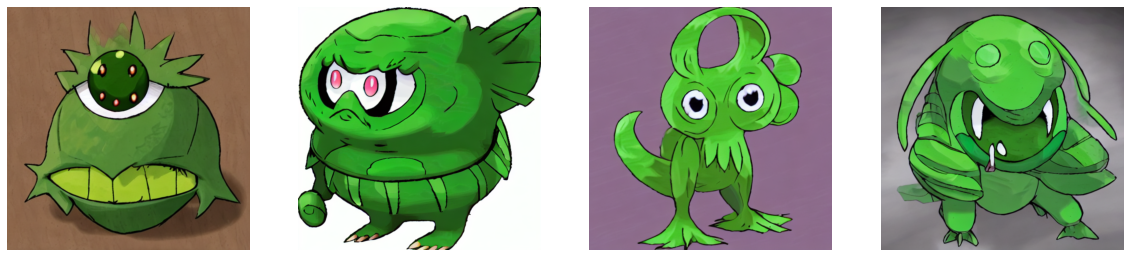

In [ ]:
plot_images(restored_reshaped)

  0%|          | 0/25 [00:00<?, ?it/s]

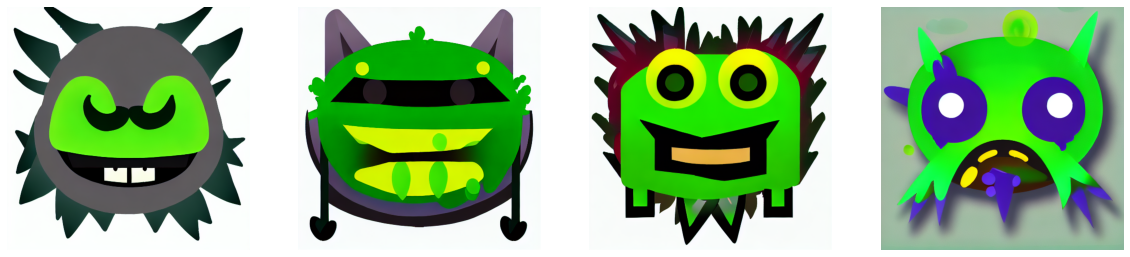

In [ ]:
# prepare sample playoad
sd_payload = {"model_path": "kuotient/noto-emoji-finetuned-lora",
              "inputs": "Green creature with menacing face",
              "num_inference_steps": 25,
              "guidance_scale": 7.5,
              "num_images_per_prompt": 4}

# test the pipeline
response = my_handler(sd_payload)

decoded = base64.b64decode(response)
restored = np.frombuffer(decoded, dtype="uint8")
restored_reshaped = np.reshape(restored, (4, 512, 512, 3))
plot_images(restored_reshaped)

  0%|          | 0/25 [00:00<?, ?it/s]

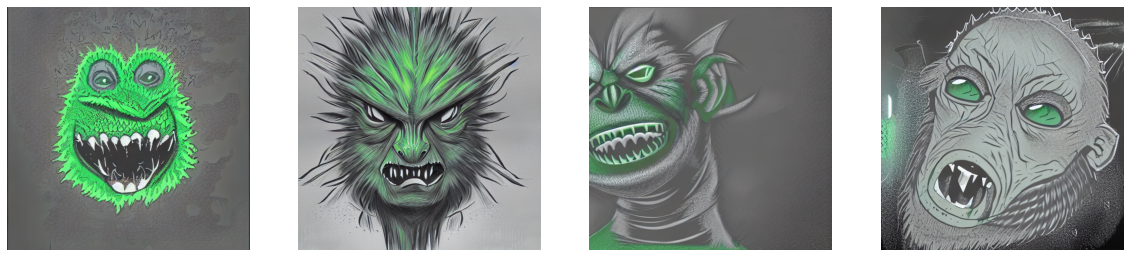

In [ ]:
# prepare sample playoad
sd_payload = {"model_path": "taesiri/ethan_ai_lora",
              "inputs": "Green creature with menacing face",
              "num_inference_steps": 25,
              "guidance_scale": 7.5,
              "num_images_per_prompt": 4}

# test the pipeline
response = my_handler(sd_payload)

decoded = base64.b64decode(response)
restored = np.frombuffer(decoded, dtype="uint8")
restored_reshaped = np.reshape(restored, (4, 512, 512, 3))
plot_images(restored_reshaped)

  0%|          | 0/25 [00:00<?, ?it/s]

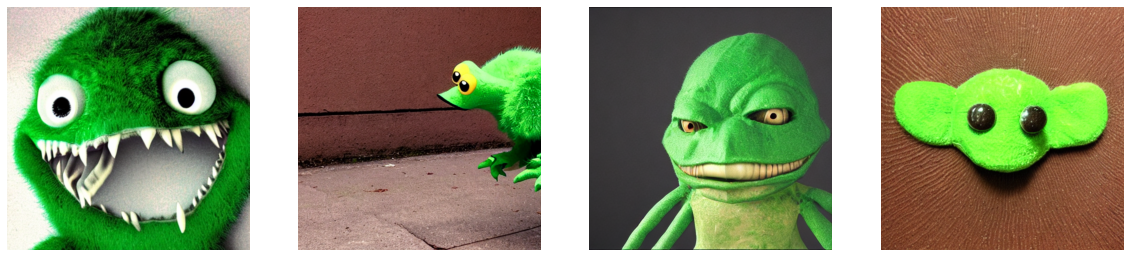

In [ ]:
# prepare sample playoad
sd_payload = {"model_path": "base",
              "inputs": "Green creature with menacing face",
              "num_inference_steps": 25,
              "guidance_scale": 7.5,
              "num_images_per_prompt": 4}

# test the pipeline
response = my_handler(sd_payload)

decoded = base64.b64decode(response)
restored = np.frombuffer(decoded, dtype="uint8")
restored_reshaped = np.reshape(restored, (4, 512, 512, 3))
plot_images(restored_reshaped)